#Image Processor

In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import torch
from torchvision import transforms

class IRImageProcessor:
    """
    Image processor for infrared sky images
    1. Normalization
    2. Bicubic interpolation for upscaling
    3. OpenCV colormap (JET) application
    """

    def __init__(self, target_size=(240, 320), colormap=cv2.COLORMAP_JET):
        self.target_size = target_size
        self.colormap = colormap

    def process_single_image(self, ir_image_path):
        """Process a single IR image following paper methodology"""
        # Read IR image (16-bit depth preserved)
        ir_image = cv2.imread(ir_image_path, cv2.IMREAD_ANYDEPTH)

        # Step 1: Normalization to 0-255 range
        img_normalized = cv2.normalize(ir_image, None, 0, 255, cv2.NORM_MINMAX)

        # Step 2: Bicubic interpolation for upscaling
        img_upscaled = cv2.resize(
            img_normalized,
            self.target_size,
            interpolation=cv2.INTER_CUBIC
        )

        # Step 3: Apply OpenCV colormap (convert to RGB)
        img_colored = cv2.applyColorMap(
            img_upscaled.astype(np.uint8),
            self.colormap
        )

        # Convert BGR to RGB for proper processing
        img_rgb = cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB)

        return img_rgb

    def process_batch_images(self, input_dir, output_dir):
        """Process all images in a directory"""
        os.makedirs(output_dir, exist_ok=True)

        image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for img_file in tqdm(image_files, desc="Processing IR images"):
            img_path = os.path.join(input_dir, img_file)
            processed_img = self.process_single_image(img_path)

            output_path = os.path.join(output_dir, img_file)
            # Save as RGB
            cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

    def get_tensor_transform(self):
        """Get PyTorch transform for processed images"""
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])


Dataset class for loading IR sky images and corresponding solar irradiance values

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import pandas as pd

class SolarIrradianceDataset(Dataset):
    """
    Dataset class for loading IR sky images and corresponding solar irradiance values
    """

    def __init__(self, image_dir, irradiance_file, transform=None, target_size=(240, 320)):
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size

        # Load irradiance data
        if irradiance_file.endswith('.csv'):
            df = pd.read_csv(irradiance_file)
            # Assuming the irradiance values are in the second column
            self.irradiance_values = df.iloc[:, 1].values.astype(np.float32)
        else:
            self.irradiance_values = np.loadtxt(irradiance_file, delimiter=',')[:, 1].astype(np.float32)

        # Get image files
        self.image_files = sorted([f for f in os.listdir(image_dir)
                                  if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Ensure we have matching number of images and irradiance values
        min_length = min(len(self.image_files), len(self.irradiance_values))
        self.image_files = self.image_files[:min_length]
        self.irradiance_values = self.irradiance_values[:min_length]

        # Initialize image processor
        self.image_processor = IRImageProcessor(target_size=target_size)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load and process image
        img_path = os.path.join(self.image_dir, self.image_files[idx])

        # Check if image is already processed (RGB) or raw IR
        img = cv2.imread(img_path)
        if img is None:
            # Try loading as 16-bit IR image
            img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
            if img is not None:
                # Process raw IR image
                img = self.image_processor.process_single_image(img_path)
            else:
                raise ValueError(f"Could not load image: {img_path}")
        else:
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert to tensor
        img_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0

        # Apply transforms if provided
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # Get corresponding irradiance value
        irradiance = torch.tensor(self.irradiance_values[idx], dtype=torch.float32)

        return img_tensor, irradiance


class SolarSequenceDataset(Dataset):
    """
    Dataset class for sequence-based training (for LSTM and hybrid model)
    """

    def __init__(self, image_dir, irradiance_file, sequence_length=20,
                 forecast_horizon=4, transform=None, target_size=(240, 320)):
        self.image_dir = image_dir
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.transform = transform
        self.target_size = target_size

        # Load irradiance data
        if irradiance_file.endswith('.csv'):
            df = pd.read_csv(irradiance_file)
            self.irradiance_values = df.iloc[:, 1].values.astype(np.float32)
        else:
            self.irradiance_values = np.loadtxt(irradiance_file, delimiter=',')[:, 1].astype(np.float32)

        # Get image files
        self.image_files = sorted([f for f in os.listdir(image_dir)
                                  if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Ensure we have enough data for sequences
        min_length = min(len(self.image_files), len(self.irradiance_values))
        self.image_files = self.image_files[:min_length]
        self.irradiance_values = self.irradiance_values[:min_length]

        # Calculate valid sequence indices
        self.valid_indices = list(range(len(self.image_files) - sequence_length - forecast_horizon + 1))

        # Initialize image processor
        self.image_processor = IRImageProcessor(target_size=target_size)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]

        # Get sequence of images
        image_sequence = []
        for i in range(start_idx, start_idx + self.sequence_length):
            img_path = os.path.join(self.image_dir, self.image_files[i])

            # Load and process image
            img = cv2.imread(img_path)
            if img is None:
                img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
                if img is not None:
                    img = self.image_processor.process_single_image(img_path)
                else:
                    raise ValueError(f"Could not load image: {img_path}")
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0

            if self.transform:
                img_tensor = self.transform(img_tensor)

            image_sequence.append(img_tensor)

        # Stack images into sequence tensor
        image_sequence = torch.stack(image_sequence)  # (seq_len, channels, height, width)

        # Get historical irradiance values (for LSTM input)
        historical_irradiance = torch.tensor(
            self.irradiance_values[start_idx:start_idx + self.sequence_length],
            dtype=torch.float32
        ).unsqueeze(-1)  # (seq_len, 1)

        # Get future irradiance values (targets)
        future_irradiance = torch.tensor(
            self.irradiance_values[start_idx + self.sequence_length:
                                 start_idx + self.sequence_length + self.forecast_horizon],
            dtype=torch.float32
        )  # (forecast_horizon,)

        return image_sequence, historical_irradiance, future_irradiance


class SolarTimeSeriesDataset(Dataset):
    """
    Simple time series dataset for LSTM-only training
    """

    def __init__(self, irradiance_file, sequence_length=20, forecast_horizon=4):
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

        # Load irradiance data
        if irradiance_file.endswith('.csv'):
            df = pd.read_csv(irradiance_file)
            self.data = df.iloc[:, 1].values.astype(np.float32)
        else:
            self.data = np.loadtxt(irradiance_file, delimiter=',')[:, 1].astype(np.float32)

        # Calculate valid indices
        self.valid_indices = list(range(len(self.data) - sequence_length - forecast_horizon + 1))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]

        # Input sequence
        x = torch.tensor(
            self.data[start_idx:start_idx + self.sequence_length],
            dtype=torch.float32
        ).unsqueeze(-1)  # (seq_len, 1)

        # Target sequence
        y = torch.tensor(
            self.data[start_idx + self.sequence_length:
                     start_idx + self.sequence_length + self.forecast_horizon],
            dtype=torch.float32
        )  # (forecast_horizon,)

        return x, y


# Legacy dataset for backward compatibility
class GSIDataset(SolarIrradianceDataset):
    """Legacy dataset class - kept for compatibility"""

    def __init__(self, image_dir, gsi_file):
        super().__init__(image_dir, gsi_file)

    def __getitem__(self, idx):
        img_tensor, irradiance = super().__getitem__(idx)
        return img_tensor, irradiance


class GSITimeSeriesDataset(SolarTimeSeriesDataset):
    """Legacy time series dataset - kept for compatibility"""

    def __init__(self, gsi_values, sequence_length=10):
        self.sequence_length = sequence_length
        self.data = gsi_values.astype(np.float32)
        self.valid_indices = list(range(len(self.data) - sequence_length))

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]
        x = torch.tensor(
            self.data[start_idx:start_idx + self.sequence_length],
            dtype=torch.float32
        ).unsqueeze(-1)
        y = torch.tensor(self.data[start_idx + self.sequence_length], dtype=torch.float32)
        return x, y

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#CNN Regression model for solar irradiance nowcasting from IR sky images.
class SolarCNNRegression(nn.Module):


    def __init__(self, input_channels=3, num_classes=1):
        super(SolarCNNRegression, self).__init__()

        # Feature extraction layers (Convolutional backbone)
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 240x320 -> 120x160

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 120x160 -> 60x80

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 60x80 -> 30x40

            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 30x40 -> 15x20

            # Fifth conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )

        # Regression head for irradiance prediction
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)  # Output: solar irradiance value
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Extract features
        features = self.features(x)

        # Regression prediction
        irradiance = self.regressor(features)

        return irradiance

#Extract features for LSTM input
    def get_features(self, x):

        with torch.no_grad():
            features = self.features(x)
            return features.flatten(1)  # Flatten for sequence input


class SolarCNNWithFeatureExtraction(SolarCNNRegression):


    def __init__(self, input_channels=3, feature_dim=512):
        super().__init__(input_channels, 1)
        self.feature_dim = feature_dim

        # Feature projection layer for LSTM input
        self.feature_projector = nn.Sequential(
            nn.Linear(512, feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

    def forward(self, x, return_features=False):
        # Extract convolutional features
        conv_features = self.features(x)
        flattened_features = conv_features.flatten(1)

        # Get irradiance prediction
        irradiance = self.regressor[-3:](
            self.regressor[:-3](flattened_features)
        )

        if return_features:
            # Project features for LSTM input
            projected_features = self.feature_projector(flattened_features)
            return irradiance, projected_features

        return irradiance


# Legacy model for backward compatibility
class SolarCNN(SolarCNNRegression):

    pass

Loading multi-day dataset...
Train samples: 8133, Val samples: 2034
Using device: cuda
Starting training for 50 epochs...
Model parameters: 1,734,913

Epoch 1/50


Training: 100%|██████████| 255/255 [01:10<00:00,  3.62it/s, Loss=6410.0474]


Train Loss: 19284.7991


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.72it/s, Val Loss=3703.2856]


Val Loss: 4345.9493, RMSE: 65.96 W/m², MAE: 57.81 W/m²
New best model saved! RMSE: 65.96 W/m²

Epoch 2/50


Training: 100%|██████████| 255/255 [00:59<00:00,  4.30it/s, Loss=3730.8738]


Train Loss: 3403.6838


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.87it/s, Val Loss=838.6480]


Val Loss: 2767.1104, RMSE: 52.73 W/m², MAE: 35.46 W/m²
New best model saved! RMSE: 52.73 W/m²

Epoch 3/50


Training: 100%|██████████| 255/255 [00:58<00:00,  4.35it/s, Loss=2076.1250]


Train Loss: 2832.6563


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.62it/s, Val Loss=2397.2415]


Val Loss: 4560.9378, RMSE: 67.64 W/m², MAE: 48.30 W/m²

Epoch 4/50


Training: 100%|██████████| 255/255 [00:58<00:00,  4.33it/s, Loss=5246.3726]


Train Loss: 2620.7843


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.68it/s, Val Loss=1217.8652]


Val Loss: 2185.6427, RMSE: 46.82 W/m², MAE: 32.67 W/m²
New best model saved! RMSE: 46.82 W/m²

Epoch 5/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.44it/s, Loss=5815.0103]


Train Loss: 2410.8668


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.82it/s, Val Loss=2155.6125]


Val Loss: 2366.4016, RMSE: 48.66 W/m², MAE: 36.88 W/m²

Epoch 6/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.44it/s, Loss=3210.3442]


Train Loss: 2290.2769


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.62it/s, Val Loss=3493.4233]


Val Loss: 3606.0621, RMSE: 60.06 W/m², MAE: 51.70 W/m²

Epoch 7/50


Training: 100%|██████████| 255/255 [00:59<00:00,  4.31it/s, Loss=3453.9204]


Train Loss: 2232.3234


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.70it/s, Val Loss=2560.7207]


Val Loss: 2870.3587, RMSE: 53.60 W/m², MAE: 45.62 W/m²

Epoch 8/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.45it/s, Loss=1706.6149]


Train Loss: 2090.9316


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.85it/s, Val Loss=1337.9674]


Val Loss: 2195.7454, RMSE: 46.92 W/m², MAE: 36.04 W/m²

Epoch 9/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.49it/s, Loss=4447.7988]


Train Loss: 2099.4593


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.79it/s, Val Loss=2443.8706]


Val Loss: 2647.0686, RMSE: 51.46 W/m², MAE: 43.88 W/m²

Epoch 10/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.50it/s, Loss=568.0480]


Train Loss: 2017.5925


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.91it/s, Val Loss=5271.7334]


Val Loss: 4577.9918, RMSE: 67.63 W/m², MAE: 58.48 W/m²

Epoch 11/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.41it/s, Loss=6328.4487]


Train Loss: 1944.0368


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.91it/s, Val Loss=2354.2485]


Val Loss: 2182.0338, RMSE: 46.70 W/m², MAE: 37.78 W/m²
New best model saved! RMSE: 46.70 W/m²

Epoch 12/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.47it/s, Loss=754.0633]


Train Loss: 2008.6999


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.89it/s, Val Loss=1135.6782]


Val Loss: 1639.4513, RMSE: 40.53 W/m², MAE: 28.93 W/m²
New best model saved! RMSE: 40.53 W/m²

Epoch 13/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.50it/s, Loss=704.4965]


Train Loss: 1832.3627


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.87it/s, Val Loss=517.5760]


Val Loss: 1800.1076, RMSE: 42.53 W/m², MAE: 28.51 W/m²

Epoch 14/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.46it/s, Loss=2644.7166]


Train Loss: 1801.7106


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.83it/s, Val Loss=1197.9709]


Val Loss: 1618.1304, RMSE: 40.26 W/m², MAE: 30.48 W/m²
New best model saved! RMSE: 40.26 W/m²

Epoch 15/50


Training: 100%|██████████| 255/255 [00:58<00:00,  4.37it/s, Loss=782.0870]


Train Loss: 1687.6007


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.83it/s, Val Loss=1859.9423]


Val Loss: 1975.7136, RMSE: 44.46 W/m², MAE: 36.44 W/m²

Epoch 16/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.43it/s, Loss=3044.4778]


Train Loss: 1715.5835


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.91it/s, Val Loss=2899.2322]


Val Loss: 3943.3031, RMSE: 62.85 W/m², MAE: 51.75 W/m²

Epoch 17/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.46it/s, Loss=1631.4352]


Train Loss: 1698.9767


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.78it/s, Val Loss=1462.1434]


Val Loss: 1745.5443, RMSE: 41.80 W/m², MAE: 33.73 W/m²

Epoch 18/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.45it/s, Loss=2426.7263]


Train Loss: 1557.2500


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.89it/s, Val Loss=1743.4952]


Val Loss: 1716.9392, RMSE: 41.43 W/m², MAE: 32.94 W/m²

Epoch 19/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.42it/s, Loss=8028.8276]


Train Loss: 1659.7151


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.92it/s, Val Loss=2319.6267]


Val Loss: 1954.2203, RMSE: 44.18 W/m², MAE: 35.81 W/m²

Epoch 20/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.43it/s, Loss=539.4736]


Train Loss: 1569.9948


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.61it/s, Val Loss=1475.5883]


Val Loss: 1859.6409, RMSE: 43.15 W/m², MAE: 35.43 W/m²

Epoch 21/50


Training: 100%|██████████| 255/255 [00:58<00:00,  4.36it/s, Loss=1822.0844]


Train Loss: 1523.5487


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.63it/s, Val Loss=7472.5312]


Val Loss: 6206.2545, RMSE: 78.72 W/m², MAE: 64.52 W/m²

Epoch 22/50


Training: 100%|██████████| 255/255 [00:58<00:00,  4.33it/s, Loss=10631.7441]


Train Loss: 1568.9850


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.84it/s, Val Loss=1155.5343]


Val Loss: 2257.1792, RMSE: 47.59 W/m², MAE: 34.94 W/m²

Epoch 23/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.45it/s, Loss=1284.0671]


Train Loss: 1547.6551


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.85it/s, Val Loss=1374.3739]


Val Loss: 1468.2991, RMSE: 38.33 W/m², MAE: 30.06 W/m²
New best model saved! RMSE: 38.33 W/m²

Epoch 24/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.47it/s, Loss=2080.0945]


Train Loss: 1455.5115


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.90it/s, Val Loss=799.7228]


Val Loss: 1264.9226, RMSE: 35.61 W/m², MAE: 25.80 W/m²
New best model saved! RMSE: 35.61 W/m²

Epoch 25/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.44it/s, Loss=2211.6440]


Train Loss: 1397.1812


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.89it/s, Val Loss=616.7317]


Val Loss: 1133.8889, RMSE: 33.73 W/m², MAE: 23.04 W/m²
New best model saved! RMSE: 33.73 W/m²

Epoch 26/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.45it/s, Loss=408.6414]


Train Loss: 1380.1815


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.80it/s, Val Loss=816.3361]


Val Loss: 1277.4182, RMSE: 35.79 W/m², MAE: 26.55 W/m²

Epoch 27/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.45it/s, Loss=4726.4712]


Train Loss: 1393.7598


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.85it/s, Val Loss=1429.3444]


Val Loss: 1533.7583, RMSE: 39.17 W/m², MAE: 31.77 W/m²

Epoch 28/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.49it/s, Loss=4432.9580]


Train Loss: 1390.1291


Validation: 100%|██████████| 64/64 [00:12<00:00,  4.94it/s, Val Loss=2153.2917]


Val Loss: 1695.1171, RMSE: 41.13 W/m², MAE: 32.46 W/m²

Epoch 29/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.44it/s, Loss=733.2897]


Train Loss: 1329.8717


Validation: 100%|██████████| 64/64 [00:12<00:00,  4.95it/s, Val Loss=1071.6760]


Val Loss: 1194.4799, RMSE: 34.57 W/m², MAE: 26.39 W/m²

Epoch 30/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.46it/s, Loss=3908.5681]


Train Loss: 1282.5579


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.86it/s, Val Loss=1143.9490]


Val Loss: 1424.8776, RMSE: 37.77 W/m², MAE: 27.97 W/m²

Epoch 31/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.48it/s, Loss=404.6901]


Train Loss: 1273.4166


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.80it/s, Val Loss=2051.0791]


Val Loss: 1651.6055, RMSE: 40.61 W/m², MAE: 32.32 W/m²

Epoch 32/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.43it/s, Loss=574.8195]


Train Loss: 1263.2448


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.83it/s, Val Loss=1850.8444]


Val Loss: 1845.8072, RMSE: 42.96 W/m², MAE: 35.59 W/m²

Epoch 33/50


Training: 100%|██████████| 255/255 [00:58<00:00,  4.34it/s, Loss=52.5751]


Train Loss: 1205.5367


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.77it/s, Val Loss=493.8732]


Val Loss: 1009.8959, RMSE: 31.83 W/m², MAE: 22.49 W/m²
New best model saved! RMSE: 31.83 W/m²

Epoch 34/50


Training: 100%|██████████| 255/255 [03:25<00:00,  1.24it/s, Loss=554.5974]


Train Loss: 1222.4591


Validation: 100%|██████████| 64/64 [00:12<00:00,  4.95it/s, Val Loss=1771.5757]


Val Loss: 1644.0561, RMSE: 40.54 W/m², MAE: 33.05 W/m²

Epoch 35/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.41it/s, Loss=1849.4590]


Train Loss: 1198.0702


Validation: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s, Val Loss=294.0110]


Val Loss: 997.6320, RMSE: 31.66 W/m², MAE: 22.04 W/m²
New best model saved! RMSE: 31.66 W/m²

Epoch 36/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.47it/s, Loss=461.5791]


Train Loss: 1195.1114


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.84it/s, Val Loss=1599.1448]


Val Loss: 1542.2162, RMSE: 39.27 W/m², MAE: 31.78 W/m²

Epoch 37/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.47it/s, Loss=248.7554]


Train Loss: 1110.9634


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.86it/s, Val Loss=4342.9463]


Val Loss: 4234.3842, RMSE: 65.07 W/m², MAE: 55.26 W/m²

Epoch 38/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.48it/s, Loss=1602.3002]


Train Loss: 1129.6049


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.90it/s, Val Loss=1157.1129]


Val Loss: 1819.8114, RMSE: 42.71 W/m², MAE: 33.40 W/m²

Epoch 39/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.45it/s, Loss=882.7202]


Train Loss: 1125.5092


Validation: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s, Val Loss=530.7458]


Val Loss: 892.6933, RMSE: 29.92 W/m², MAE: 20.91 W/m²
New best model saved! RMSE: 29.92 W/m²

Epoch 40/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.44it/s, Loss=1188.7301]


Train Loss: 1062.9712


Validation: 100%|██████████| 64/64 [00:12<00:00,  4.94it/s, Val Loss=1506.4097]


Val Loss: 1520.3217, RMSE: 38.99 W/m², MAE: 31.09 W/m²

Epoch 41/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.48it/s, Loss=68.1789]


Train Loss: 1134.0514


Validation: 100%|██████████| 64/64 [00:12<00:00,  4.95it/s, Val Loss=1291.2418]


Val Loss: 1282.1652, RMSE: 35.81 W/m², MAE: 28.10 W/m²

Epoch 42/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.49it/s, Loss=317.1733]


Train Loss: 1034.4749


Validation: 100%|██████████| 64/64 [00:12<00:00,  4.95it/s, Val Loss=447.5511]


Val Loss: 792.7864, RMSE: 28.20 W/m², MAE: 19.07 W/m²
New best model saved! RMSE: 28.20 W/m²

Epoch 43/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.47it/s, Loss=580.6328]


Train Loss: 1068.9612


Validation: 100%|██████████| 64/64 [00:12<00:00,  4.93it/s, Val Loss=5135.2915]


Val Loss: 4428.5984, RMSE: 66.51 W/m², MAE: 56.20 W/m²

Epoch 44/50


Training: 100%|██████████| 255/255 [00:58<00:00,  4.39it/s, Loss=991.7578]


Train Loss: 1000.9468


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.92it/s, Val Loss=2039.2885]


Val Loss: 3982.4753, RMSE: 63.21 W/m², MAE: 53.29 W/m²

Epoch 45/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.50it/s, Loss=1460.3046]


Train Loss: 1267.5921


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.85it/s, Val Loss=362.1393]


Val Loss: 972.5924, RMSE: 31.25 W/m², MAE: 22.03 W/m²

Epoch 46/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.50it/s, Loss=1251.9940]


Train Loss: 1039.3781


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.90it/s, Val Loss=1966.2045]


Val Loss: 3203.0279, RMSE: 56.67 W/m², MAE: 47.40 W/m²

Epoch 47/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.45it/s, Loss=999.1468]


Train Loss: 1020.3826


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.76it/s, Val Loss=3655.6067]


Val Loss: 3079.9190, RMSE: 55.46 W/m², MAE: 46.43 W/m²

Epoch 48/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.41it/s, Loss=60.6438]


Train Loss: 946.7293


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.81it/s, Val Loss=532.8173]


Val Loss: 1034.7305, RMSE: 32.22 W/m², MAE: 22.98 W/m²

Epoch 49/50


Training: 100%|██████████| 255/255 [00:56<00:00,  4.48it/s, Loss=1777.3124]


Train Loss: 955.6912


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.83it/s, Val Loss=284.0763]


Val Loss: 962.9690, RMSE: 31.11 W/m², MAE: 21.43 W/m²

Epoch 50/50


Training: 100%|██████████| 255/255 [00:57<00:00,  4.42it/s, Loss=2999.1694]


Train Loss: 993.3808


Validation: 100%|██████████| 64/64 [00:13<00:00,  4.63it/s, Val Loss=2164.2627]


Val Loss: 2208.8223, RMSE: 47.00 W/m², MAE: 38.78 W/m²
Training completed!


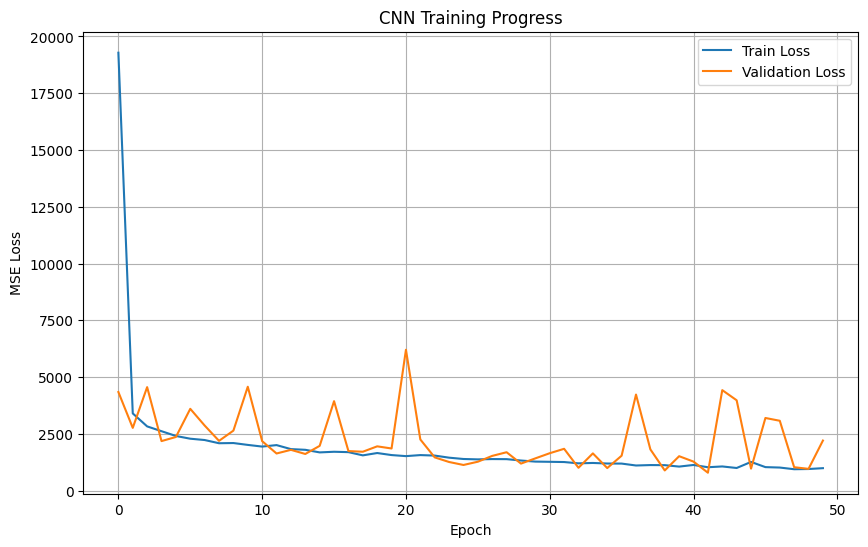

CNN nowcasting training completed!


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json
import cv2  

class MultiDayDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, irradiance_values):
        self.image_paths = image_paths
        self.irradiance_values = irradiance_values
        self.image_processor = IRImageProcessor(target_size=(240, 320))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        if img is None:
            img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
            img = self.image_processor.process_single_image(img_path)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0
        irradiance = torch.tensor(self.irradiance_values[idx], dtype=torch.float32)
        return img_tensor, irradiance

def get_multi_day_dataset(image_dirs, irradiance_files):
    image_paths = []
    irradiance_values = []

    for img_dir, irr_file in zip(image_dirs, irradiance_files):
        # Load irradiance data
        if irr_file.endswith('.csv'):
            df = pd.read_csv(irr_file)
            values = df.iloc[:, 1].values.astype(np.float32)
        else:
            values = np.loadtxt(irr_file, delimiter=',')[:, 1].astype(np.float32)

        files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        files = files[:len(values)]  # Ensure matching length

        image_paths.extend([os.path.join(img_dir, f) for f in files])
        irradiance_values.extend(values[:len(files)])

    return MultiDayDataset(image_paths, irradiance_values)

class CNNTrainer:
    """
    Trainer class for CNN nowcasting model following paper methodology
    """

    def __init__(self, model_type='standard', config=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Default configuration
        self.config = {
            'learning_rate': 1e-4,
            'batch_size': 32,
            'num_epochs': 50,
            'weight_decay': 1e-4,
            'scheduler_patience': 10,
            'early_stopping_patience': 15,
            'save_dir': 'models',
            'log_dir': 'logs'
        }

        if config:
            self.config.update(config)

        # Create directories
        os.makedirs(self.config['save_dir'], exist_ok=True)
        os.makedirs(self.config['log_dir'], exist_ok=True)

        # Initialize model
        if model_type == 'with_features':
            self.model = SolarCNNWithFeatureExtraction().to(self.device)
        else:
            self.model = SolarCNNRegression().to(self.device)

        # Initialize optimizer and scheduler
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.config['learning_rate'],
            weight_decay=self.config['weight_decay']
        )

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.config['scheduler_patience'],
            factor=0.5,
        )

        self.criterion = nn.MSELoss()

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        with tqdm(train_loader, desc="Training") as pbar:
            for batch_idx, (images, targets) in enumerate(pbar):
                images, targets = images.to(self.device), targets.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs.squeeze(), targets)

                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                # Update progress bar
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        return total_loss / num_batches

    def validate_epoch(self, val_loader):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0.0
        predictions = []
        targets = []

        with torch.no_grad():
            with tqdm(val_loader, desc="Validation") as pbar:
                for images, batch_targets in pbar:
                    images, batch_targets = images.to(self.device), batch_targets.to(self.device)

                    outputs = self.model(images)
                    loss = self.criterion(outputs.squeeze(), batch_targets)

                    total_loss += loss.item()

                    predictions.extend(outputs.squeeze().cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

                    pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(val_loader)

        # Calculate additional metrics
        predictions = np.array(predictions)
        targets = np.array(targets)

        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, predictions)

        return avg_loss, rmse, mae, predictions, targets

    def train(self, train_loader, val_loader=None):
        """Main training loop"""
        print(f"Starting training for {self.config['num_epochs']} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        for epoch in range(self.config['num_epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['num_epochs']}")

            # Training
            train_loss = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)

            print(f"Train Loss: {train_loss:.4f}")

            # Validation
            if val_loader is not None:
                val_loss, rmse, mae, predictions, targets = self.validate_epoch(val_loader)
                self.val_losses.append(val_loss)

                print(f"Val Loss: {val_loss:.4f}, RMSE: {rmse:.2f} W/m², MAE: {mae:.2f} W/m²")

                # Learning rate scheduling
                self.scheduler.step(val_loss)

                # Early stopping and model saving
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.patience_counter = 0

                    # Save best model
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_loss,
                        'config': self.config
                    }, os.path.join(self.config['save_dir'], 'best_cnn_model.pth'))

                    print(f"New best model saved! RMSE: {rmse:.2f} W/m²")
                else:
                    self.patience_counter += 1

                if self.patience_counter >= self.config['early_stopping_patience']:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Save final model
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(self.config['save_dir'], 'final_cnn_model.pth'))

        # Save training history
        history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': self.config
        }

        with open(os.path.join(self.config['log_dir'], 'cnn_training_history.json'), 'w') as f:
            json.dump(history, f, indent=2)

        print("Training completed!")
        return self.train_losses, self.val_losses

    def load_model(self, checkpoint_path):
        """Load a saved model"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        return checkpoint

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        predictions = []
        targets = []

        with torch.no_grad():
            for images, batch_targets in tqdm(test_loader, desc="Evaluating"):
                images, batch_targets = images.to(self.device), batch_targets.to(self.device)

                outputs = self.model(images)
                predictions.extend(outputs.squeeze().cpu().numpy())
                targets.extend(batch_targets.cpu().numpy())

        predictions = np.array(predictions)
        targets = np.array(targets)

        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets, predictions)

        print(f"Test Results - RMSE: {rmse:.2f} W/m², MAE: {mae:.2f} W/m²")

        return rmse, mae, predictions, targets

def train_cnn_nowcasting():
    """Main function to train CNN nowcasting model"""

    # Configuration
    config = {
        'learning_rate': 1e-4,
        'batch_size': 32,
        'num_epochs': 50,
        # List of days
        'image_dirs': [
            '/content/drive/MyDrive/data/processed/2019_01_15',
            '/content/drive/MyDrive/data/processed/2019_01_16',
            '/content/drive/MyDrive/data/processed/2019_01_17',
            '/content/drive/MyDrive/data/processed/2019_01_18',
            '/content/drive/MyDrive/data/processed/2019_01_19',
            '/content/drive/MyDrive/data/processed/2019_01_20'
        ],
        'irradiance_files': [
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_15/pyranometer/2019_01_15.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_16/pyranometer/2019_01_16.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_17/pyranometer/2019_01_17.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/pyranometer/2019_01_18.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_19/pyranometer/2019_01_19.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_20/pyranometer/2019_01_20.csv'
        ]
    }

    # Create multi-day dataset
    print("Loading multi-day dataset...")
    dataset = get_multi_day_dataset(config['image_dirs'], config['irradiance_files'])

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2 # Reduced number of workers
        )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2 # Reduced number of workers
    )

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    # Initialize trainer
    trainer = CNNTrainer(model_type='standard', config=config)

    # Train model
    train_losses, val_losses = trainer.train(train_loader, val_loader)

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('CNN Training Progress')
    plt.legend()
    plt.grid(True)
    plt.savefig('logs/cnn_training_curves.png')
    plt.show()

    print("CNN nowcasting training completed!")

if __name__ == '__main__':
    train_cnn_nowcasting()